In [161]:
import warnings
warnings.filterwarnings('ignore')

In [162]:
import numpy as np
from scipy.optimize import curve_fit

In [163]:
import matplotlib.pyplot as plt
from plotting import initialize_plot_settings
initialize_plot_settings()

In [164]:
from disloc import deform_dislocation
from utils import load_and_mask_results

In [165]:
ORIGIN_X = 321660
ORIGIN_Y = 4164942

## 1D model, Lidar - 100m depth, 1 m dip slip

In [120]:
def center_profiles(uobs, utrue, dx=1):
    n = len(uobs)
    idx = np.where(uobs == np.sign(uobs) * np.min(np.abs(uobs)))[0][0]
    xp = np.arange(2*(n - idx), dtype=float)
    xp -= np.mean(xp)
    x = dx * xp - dx / 2
    if 2*idx - n < 0:
        return x[np.abs(2*idx - n)+1:], uobs[np.abs(2*idx - n):], utrue[np.abs(2*idx - n):]        
    return x, uobs[(2*idx - n):], utrue[(2*idx - n):]

In [156]:
def rmse(ytrue, yhat):
    return np.sqrt(np.mean((yhat - ytrue) ** 2))

In [133]:
def model_1d(x, depth, s):
    delta = 89.999
    deltarad = np.deg2rad(delta)
    zeta = (x / depth) - (1 / np.tan(deltarad))
    u1 = (s/np.pi)*(np.cos(deltarad)*np.arctan(zeta) + (np.sin(deltarad) - zeta*np.cos(deltarad))/(1+np.power(zeta,2)))
    u2 = (-s/np.pi)*(np.sin(deltarad)*np.arctan(zeta) + (np.cos(deltarad) + zeta*np.sin(deltarad))/(1+np.power(zeta,2)))
    return u2

In [ ]:
depth = 100
dip_slip = 1
dxs = [5, 12.5, 25, 50, 100]

In [ ]:
us = np.load('profiles/lidar_ds_applied.npy', allow_pickle=True)

In [ ]:
uicps = np.load('profiles/lidar_ds_observed.npy', allow_pickle=True)

In [ ]:
dx = dxs[0]
uobs = uicps[0]
utrue = us[0]

In [ ]:
xp, uobsc, utruec = center_profiles(uobs, utrue, dx=dx)
phat, pcov = curve_fit(model_1d, xp, uobsc)
uhat = model_1d(xp, *phat)
print(phat)

In [ ]:
plt.plot(xp, uobsc, 'wo', mec='k', label='ICP')
plt.plot(xp, utruec, 'k-', label='True')
plt.plot(xp, uhat, 'k--', label='Best fit')
plt.legend()

In [ ]:
fig, axes = plt.subplots(len(dxs), 1, figsize=(6, 3 * len(dxs)), sharex=True)
letters = ['A', 'B', 'C', 'D', 'E']
for ax, letter, dx, utrue, uobs in zip(axes, letters, dxs, us, uicps):
    x, uobsc, _ = center_profiles(uobs, utrue, dx=dx)
    phat, pcov = curve_fit(model_1d, x, uobsc)
    uhat = model_1d(xp, *phat)
    ax.plot(x, uobsc, 'wo', mec='k', label='Measured (ICP)')
    ax.plot(xp, utruec, 'k-', label='True')
    ax.plot(xp, uhat, 'k--', label='Best fit')
        
    ax.text(0.025, 0.9, letter, transform=ax.transAxes, fontsize=14)
    ax.text(0.75, 0.1, "$dx$ = " + f"{dx:.1f} m\n" + "$\hat{d}$ = " + f"{phat[0]:.2f} m \n" + "$\hat{s_z}$ = " + f"{phat[1]:.2f} m", transform=ax.transAxes, fontsize=14)
        
axes[0].legend()        
axes[-1].set_xticks([-400, 0, 400])
axes[-1].set_xticklabels(['0', '400', '800'])
axes[-1].set_xlabel('Distance [m]')
axes[2].set_ylabel('Displacement $u_z$ [m]')

plt.savefig('/home/rmsare/fig/hsl_icp/FigureSX_LidarResolutionDSModels.png', dpi=300, bbox_inches='tight')

## 2D model, Lidar - 100m depth, 1 m dip slip

In [380]:
def model_2d(coords, strike, dip, depth, slip_ds, slip_ss, origin_x, origin_y):
    n = int(coords.shape[0] / 3)
    x = coords[0:n]
    y = coords[n:2*n]
    z = np.zeros_like(x)
    xd, yd, uz = deform_dislocation(x, y, z, dip=dip, strike=strike, depth=depth, slip_ss=slip_ss, slip_ds=slip_ds, origin_x=origin_x, origin_y=origin_y)
    ux = xd - x
    uy = yd - y
    res = np.vstack([ux.reshape(-1,1), uy.reshape(-1,1), uz.reshape(-1,1)])
    return res.flatten()

In [381]:
def get_unmasked_result(umasked, mask):
    u = np.full(mask.shape, fill_value=np.nan)
    u[mask] = umasked
    return u

In [393]:
depth = 100
strike = 310
dip = 89.999
ds = 1
dxw = 50
filename = f'results/lidar/dip_slip/HSLLidar_2017_s{strike:.2f}_d90.00_dep{depth:.2f}_ss0.00_ds{ds:.2f}_ICP_w{dxw:.2f}_str{dxw / 2:.2f}.pkl'
x, y, ux, uy, uz, residual, mask = load_and_mask_results(filename)
xx, yy = np.meshgrid(x, y)
coords = np.stack([xx.ravel(), yy.ravel()], axis=-1)
masked_uobs = np.vstack([ux[mask].ravel().reshape(-1,1), uy[mask].ravel().reshape(-1,1), uz[mask].ravel().reshape(-1,1)]).flatten()
masked_coords = coords[mask.ravel(), :]
stacked_coords = np.vstack([masked_coords[:, 0], masked_coords[:, 1], masked_coords[:, 0], masked_coords[:, 1], masked_coords[:, 0], masked_coords[:, 1]]).flatten()

In [394]:
print(stacked_coords.shape, masked_uobs.shape)

(8802,) (4401,)


In [384]:
ptrue = (strike, dip, depth, ds, 0, ORIGIN_X, ORIGIN_Y)
utruem = model_2d(stacked_coords, *ptrue)

In [396]:
print(utruem.shape[0] / 3, np.sum(mask))

2934.0 1467


In [390]:
n = int(utruem.shape[0] / 3)

In [391]:
uxtrue = get_unmasked_result(utruem[0:n], mask)
uytrue = get_unmasked_result(utruem[n:2*n], mask)
uztrue = get_unmasked_result(utruem[2*n:], mask)

ValueError: NumPy boolean array indexing assignment cannot assign 2934 input values to the 1467 output values where the mask is true

In [334]:
phat, pcov = curve_fit(model_2d, stacked_coords, masked_uobs)

ValueError: object too deep for desired array

error: Result from function call is not a proper array of floats.

In [324]:
uhatm = model_2d(stacked_coords, *phat)

ValueError: object too deep for desired array

error: Result from function call is not a proper array of floats.

In [235]:
uxhat = get_unmasked_result(uhatm[:, 0], mask)
uyhat = get_unmasked_result(uhatm[:, 1], mask)
uzhat = get_unmasked_result(uhatm[:, 2], mask)

NameError: name 'uhatm' is not defined

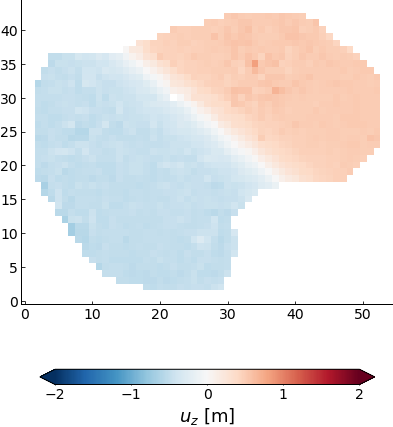

In [234]:
im = plt.imshow(uz, cmap='RdBu_r', vmin=-2, vmax=2, origin='lower')
plt.colorbar(im, label='$u_z$ [m]', shrink=0.75, orientation='horizontal', extend='both')

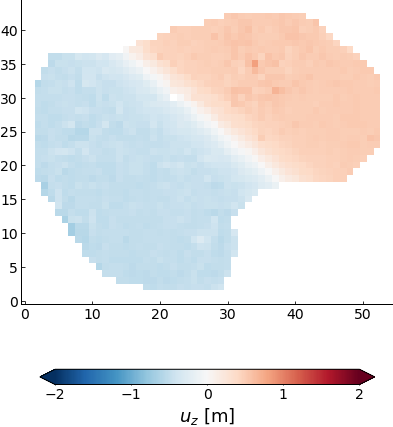

In [234]:
im = plt.imshow(uz, cmap='RdBu_r', vmin=-2, vmax=2, origin='lower')
plt.colorbar(im, label='$u_z$ [m]', shrink=0.75, orientation='horizontal', extend='both')